# HSMAC法による2D cavity flow
* staggerd mesh
* restartできるようにした

In [1]:
using LinearAlgebra
using Parameters
using PyPlot
using BenchmarkTools
using HDF5

In [2]:
@with_kw struct Param{T1,T2}
    dt::T1 = 0.01
    # viscosity
    nu::T1 = 1e-2
    # boundary velocity
    U::T1 = 1.0
    nstep::T2 = 200
    omega::T1 = 1.7
    # max iteration no. of inner iteration
    niter::T2 = 50000
    
    nx::T2 = 40
    ny::T2 = 40
    
    # length
    Lx::T1 = 1.0
    Ly::T1 = 1.0
    dx::T1 = Lx/nx
    dy::T1 = Ly/ny
   
    ndata::T2 = 100
     
    outfile::String = "Data/uv" 

end

Param

In [3]:
para = Param(nstep=1000, ndata=100, )
#para = Param(nstep=1000, ndata=100,)
#para = Param(nstep=2000, nu=2.5e-3, ndata=100, outfile="Cavity/uvRe400_", nx=80, ny=80, )
#para = Param(nstep=3000, nu=2.5e-3, ndata=100, outfile="Cavity/uvRe400fine_", nx=129, ny=129, dt=5e-3)

Param{Float64,Int64}
  dt: Float64 0.01
  nu: Float64 0.01
  U: Float64 1.0
  nstep: Int64 1000
  omega: Float64 1.7
  niter: Int64 50000
  nx: Int64 40
  ny: Int64 40
  Lx: Float64 1.0
  Ly: Float64 1.0
  dx: Float64 0.025
  dy: Float64 0.025
  ndata: Int64 100
  outfile: String "Data/uv"


In [17]:
function main(para)
    @unpack nx, ny, nstep, ndata = para
    # velocity
    u = zeros(Float64, nx+2, ny+2)
    v = zeros(Float64, nx+2, ny+2)
    # auxiliary velocity
    ua = zeros(Float64, nx+2, ny+2)
    va = zeros(Float64, nx+2, ny+2)
    # pressure, corrected pressure
    pa = zeros(Float64, nx+2, ny+2)
    pc = zeros(Float64, nx+2, ny+2)
    # coordinate
    x = zeros(Float64, nx+1, ny+1)
    y = zeros(Float64, nx+1, ny+1)
    # stream function
    psi = zeros(Float64, nx+2, ny+2)
    
    uo = zeros(nx+1, ny+1)
    vo = zeros(nx+1, ny+1)
    uxy = zeros(nx+1, ny+1)
    vxy = zeros(nx+1, ny+1)
    div = zeros(Float64, nx+2, ny+2)
    
    init(para, x, y)
    BC(para, u, v)
    @simd for n = 1:nstep
        solveV(para, u, v, ua, va, pa, uo, vo, uxy, vxy)
        SOLA(para, n, u, v, ua, va, pa, pc, div)
        if n%ndata == 0
            println(n, " th step")
            streamfunction(para, u, v, psi)
            output(para, n, u, v, pa, psi, x, y)
            #println("u[20,20]=",u[21,21])
        end
    end
end

function main(para, restartFile)
    @unpack nx, ny, nstep, ndata = para
    # velocity
    u = zeros(Float64, nx+2, ny+2)
    v = zeros(Float64, nx+2, ny+2)
    # auxiliary velocity
    ua = zeros(Float64, nx+2, ny+2)
    va = zeros(Float64, nx+2, ny+2)
    # pressure, corrected pressure
    pa = zeros(Float64, nx+2, ny+2)
    pc = zeros(Float64, nx+2, ny+2)
    # coordinate
    x = zeros(Float64, nx+1, ny+1)
    y = zeros(Float64, nx+1, ny+1)
    # stream function
    psi = zeros(Float64, nx+2, ny+2)
    
    uo = zeros(nx+1, ny+1)
    vo = zeros(nx+1, ny+1)
    uxy = zeros(nx+1, ny+1)
    vxy = zeros(nx+1, ny+1)
    div = zeros(Float64, nx+2, ny+2)
    
    nstart = 0
    
    nstart = restart(para, restartFile, x, y, u, v, pa, nstart)
    println("nstart=",nstart)
    println(size(u), size(v), size(pa))
    println(u[5,:], v[5,:], pa[5,:])
    
    BC(para, u, v)
    for n = nstart+1:nstart+nstep
        solveV(para, u, v, ua, va, pa, uo, vo, uxy, vxy)
        SOLA(para, n, u, v, ua, va, pa, pc, div)
        if n%ndata == 0
            println(n, " th step")
            streamfunction(para, u, v, psi)
            output(para, n, u, v, pa, psi, x, y)
            #println("u[20,20]=",u[21,21])
        end
    end
end

main (generic function with 2 methods)

In [5]:
function init(para, x, y)
    @unpack nx, ny, dx, dy = para
    
    for j in 2:ny+1
        for i in 2:nx+1
            x[i,j] = (i-2+0.5)*dx
        end
    end
    for j in 2:ny+1
        for i in 2:nx+1
            y[i,j] = (j-2+0.5)*dy
        end
    end
end

init (generic function with 1 method)

In [20]:
function restart(para, restartFile, x, y, u, v, pa, nstart)
    @unpack nx, ny, dx, dy = para
    for j in 2:ny+1
        for i in 2:nx+1
            x[i,j] = (i-2+0.5)*dx
        end
    end
    for j in 2:ny+1
        for i in 2:nx+1
            y[i,j] = (j-2+0.5)*dy
        end
    end
    
    file = h5open(restartFile, "r") 
    u .= read(file, "u_latest")
    v .= read(file, "v_latest")
    pa .= read(file, "pa_latest")
    nstart = read(file, "n")
    
    return nstart
end

restart (generic function with 1 method)

In [7]:
function BC(para, u, v)
    @unpack nx, ny, U = para
    
    for i=1:nx+2
        u[i, ny+2] = 2.0U - u[i, ny+1]
        v[i, ny+1] = 0.0
        u[i, 1] = -u[i, 2]
        v[i, 1] = 0.0
    end
    for j=1:ny+2
        u[nx+1, j] = 0.0
        v[nx+2, j] = -v[nx+1, j]
        u[1, j] = 0.0
        v[1,j] = -v[2, j]
    end
    #println("BC",u[nx-1:nx+2,ny-1:ny+2])
end

BC (generic function with 1 method)

In [8]:
function solveV(para, u, v, ua, va, pa, uo, vo, uxy, vxy)
    @unpack dt, nu, dx, dy, nx, ny, U = para

    for j=2:ny+1
        for i=2:nx+1
            uo[i,j] = (u[i,j] + u[i-1,j])*0.5
            vo[i,j] = (v[i,j] + v[i,j-1])*0.5
            uxy[i,j] = (u[i,j+1] + u[i,j])*0.5
            vxy[i,j] = (v[i+1,j] + v[i,j])*0.5
        end
    end    
    
    for j=2:ny+1
        for i=2:nx
            ua[i,j] = u[i,j] + dt*(
                -(uo[i+1,j]^2 - uo[i,j]^2)/dx
                -(uxy[i,j]*vxy[i,j] - uxy[i,j-1]*vxy[i,j-1])/dy
                + nu*(u[i+1,j] -2.0u[i,j] + u[i-1,j])/dx^2
                + nu*(u[i,j+1] -2.0u[i,j] + u[i,j-1])/dy^2
                - (pa[i+1,j] - pa[i,j])/dx
                )
        end
    end
    
    for j=2:ny
        for i=2:nx+1
            va[i,j] = v[i,j] + dt*(
                -(uxy[i,j]*vxy[i,j] - uxy[i-1,j]*vxy[i-1,j])/dx
                -(vo[i,j+1]^2 - vo[i,j]^2)/dy
                + nu*(v[i+1,j] -2.0v[i,j] + v[i-1,j])/dx^2
                + nu*(v[i,j+1] -2.0v[i,j] + v[i,j-1])/dy^2
                - (pa[i,j+1] - pa[i,j])/dy
                )
        end
    end
    BC(para, ua, va)
    
    #println("solveV", ua[nx-1:nx+2,ny-1:ny+2])
end

solveV (generic function with 1 method)

In [9]:
function SOLA(para, n, u, v, ua, va, pa, pc, div)
    @unpack dt, nu, dx, dy, nx, ny, niter, omega = para
    
    for m=1:niter
        divmax::Float64 = 0.0
        for j=2:ny+1
            for i=2:nx+1
                div[i,j] = (ua[i,j] - ua[i-1,j])/dx + (va[i,j] - va[i,j-1])/dy
                divmax = max(abs(div[i,j]), divmax)
                pc[i,j] = - omega*div[i,j]/dt/(1.0/dx^2 + 1.0/dy^2)*0.5
                ua[i,j] = ua[i,j] + dt/dx*pc[i,j]
                ua[i-1,j] = ua[i-1,j] - dt/dx*pc[i,j]
                va[i,j] = va[i,j] + dt/dy*pc[i,j]
                va[i,j-1] = va[i,j-1] - dt/dy*pc[i,j]
                pa[i,j] = pa[i,j] + pc[i,j]
            end
        end    
        if divmax <= 1e-8
            if n%200 == 0
            #    println("divmax=", divmax)
            #    println("iter, max/min div=", m, ", ", findmax(abs.(view(div,2:nx+1, 2:ny+1))), ", ", findmin(abs.(view(div,2:nx+1, 2:ny+1))))
            println("iter=", m)
            end
            break
        end
    end
    
    for j=2:ny+1
        for i=2:nx
            u[i,j] = ua[i,j]
        end
    end
    for j=2:ny
        for i=2:nx+1
            v[i,j] = va[i,j]
        end
    end
    BC(para, u, v)
    
    #println("sola",u[nx-1:nx+2,ny-1:ny+2])
end

SOLA (generic function with 1 method)

In [10]:
function output(para, n, u, v, pa, psi, x, y)
    @unpack outfile, dt, nx, ny = para
    time = string(dt*n)
    #println("time=", time)
    filename = outfile*time*".h5"
    h5open(filename, "w") do file
        write(file, "U", (u[2:nx+1, 2:ny+1]+u[1:nx, 2:ny+1])/2)
        write(file, "V", (v[2:nx+1, 2:ny+1]+v[2:nx+1, 1:ny])/2)
        write(file, "P", pa[2:nx+1, 2:ny+1])
        write(file, "Psi", psi[2:nx+1, 2:ny+1])
        write(file, "X", x[2:nx+1, 2:ny+1])
        write(file, "Y", y[2:nx+1, 2:ny+1])
        write(file, "u_latest", u)
        write(file, "v_latest", v)
        write(file, "pa_latest", pa)
        write(file, "n", n)
    end
    
    #open( outfile*time*".csv", "w")　 do f
    #    println(f, "x, y, u, v, pa")
    #    for j=2:ny+1
    #        for i=2:nx+1
    #            println(f, x[i,j], ",", y[i,j], ",",(u[i,j]+u[i-1,j])/2., ",", (v[i,j]+v[i,j-1])/2.0, ", ", pa[i,j] )
    #        end
    #    end
    #end
end

output (generic function with 1 method)

In [11]:
function streamfunction(para, u, v, psi)
    @unpack dx, dy, nx, ny = para
    
    for j=2:ny+1
        for i=2:nx+1
            for k=2:j
                psi[i,j] += u[i,k]*dy
            end
        end
    end
                  
end

streamfunction (generic function with 1 method)

# Run and post operation

In [ ]:
@time main(para)

In [21]:
@time main(para, "Data/uv10.0.h5")

nstart=1000
(42, 42)(42, 42)(42, 42)
[0.00023723112950922566, -0.00023723112950922566, -0.0015361194955278506, -0.0032741501960426274, -0.005216222520761776, -0.007223858202294942, -0.00921729659309107, -0.011150387808572249, -0.012994864380807497, -0.014730978053736611, -0.0163422375434511, -0.017812717081975526, -0.019125973908031293, -0.020264998248428364, -0.021212858266342918, -0.021953840322143658, -0.022474959299694102, -0.022767751864787373, -0.022830286193094133, -0.022669338240007022, -0.02230270688330094, -0.021761675825410505, -0.021093684500494606, -0.020365345899091555, -0.019666042893573574, -0.019112430693121955, -0.01885422940983954, -0.019081608886165786, -0.020034029462435758, -0.02200913221984188, -0.025367136486713984, -0.030518914196342287, -0.03786928189682205, -0.047649003660397836, -0.05948106300063434, -0.07132361776454363, -0.07698319116075372, -0.060565141984427626, 0.014357386431674276, 0.21897223577066227, 0.6537458011841296, 1.3462541988158705][0.0, 0.000

# 作図

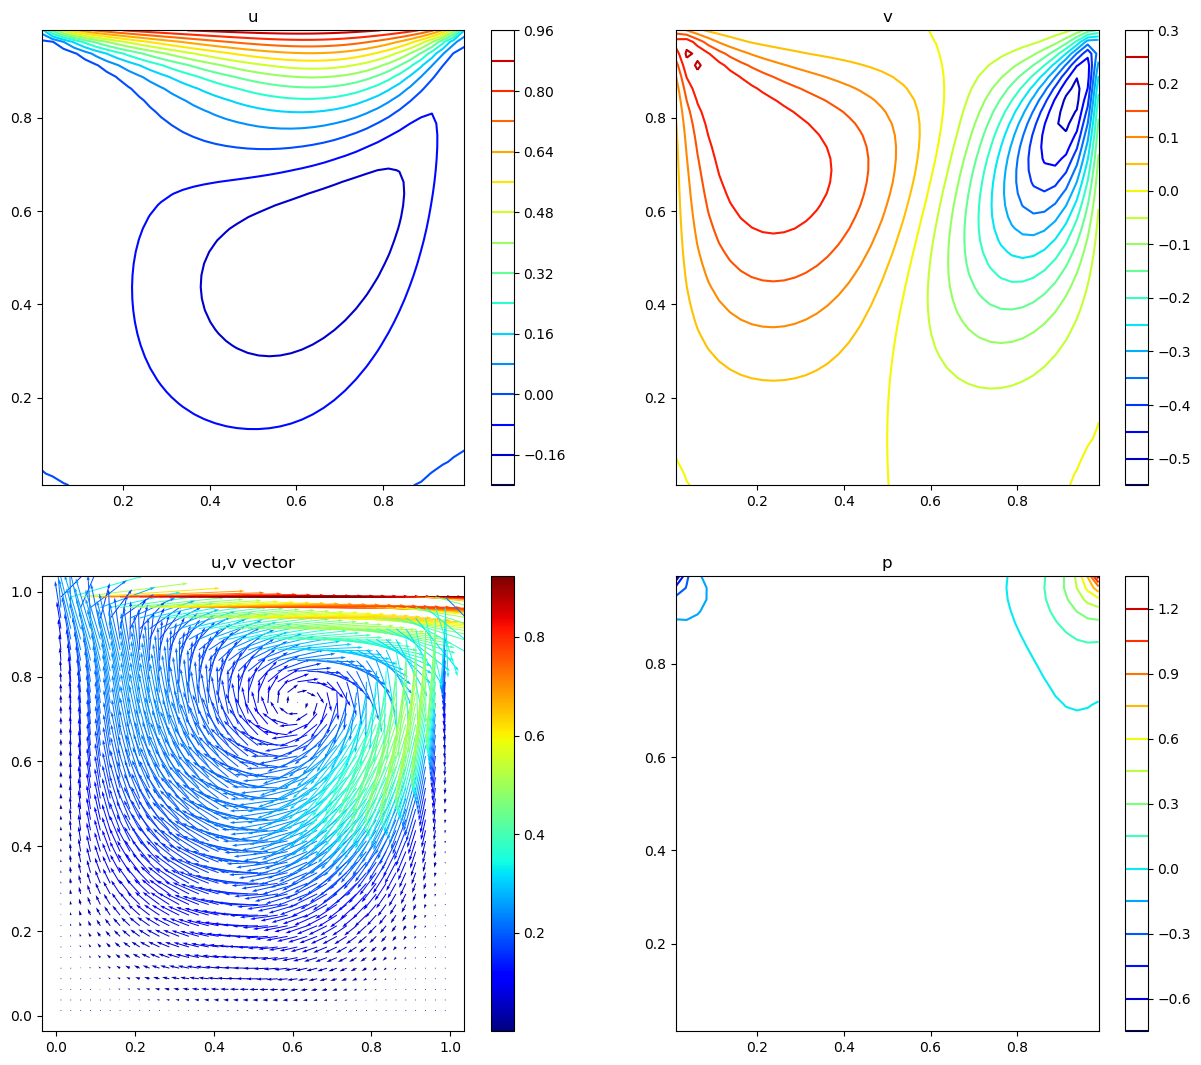

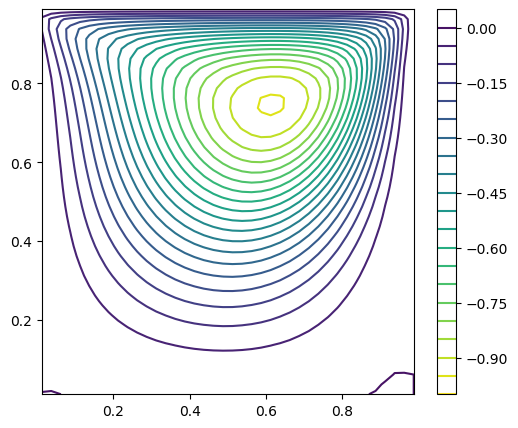

In [15]:
name = "uv10.0"
filename = "Data/"*name*".h5"
file = h5open(filename, "r") 
u = read(file, "U")
v = read(file, "V")
x = read(file, "X")
y = read(file, "Y")
pa = read(file, "P")
psi = read(file, "Psi")

close(file)

X = x[:,1]
Y = y[1,:]
fig = plt.figure(figsize = (15, 13))
ax1 = fig.add_subplot(221)
heatmap = ax1.contour(X', Y, u', cmap="jet", levels=15 )
fig.colorbar(heatmap, ax=ax1)
ax1.set_title("u")

ax2 = fig.add_subplot(222)
heatmap2 = ax2.contour(X', Y, v', cmap="jet", levels=15)
fig.colorbar(heatmap2, ax=ax2)
ax2.set_title("v")

ax3 = fig.add_subplot(223)
umag = sqrt.(u.*u .+ v.*v)
#image = ax3.quiver(x[:, 20:40], y[:, 20:40], u[:, 20:40], v[:, 20:40], umag, scale=4, cmap="jet")
image = ax3.quiver(x[:, :], y[:, :], u[:,:], v[:, :], umag, scale=2, cmap="jet")
#image = ax3.streamplot(x', y', u, v)
cb=fig.colorbar(image, ax=ax3)
ax3.set_title("u,v vector")

ax4 = fig.add_subplot(224)
heatmap3 = ax4.contour(X', Y, pa', cmap="jet", levels=15)
fig.colorbar(heatmap3, ax=ax4)
ax4.set_title("p")
plt.savefig("Fig/uv-vec"*name*".png")

fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(111)
st = ax1.contour(X', Y, psi', cmap="viridis_r", levels=20)
fig.colorbar(st, ax=ax1)
plt.savefig("Fig/stream"*name*".pdf")




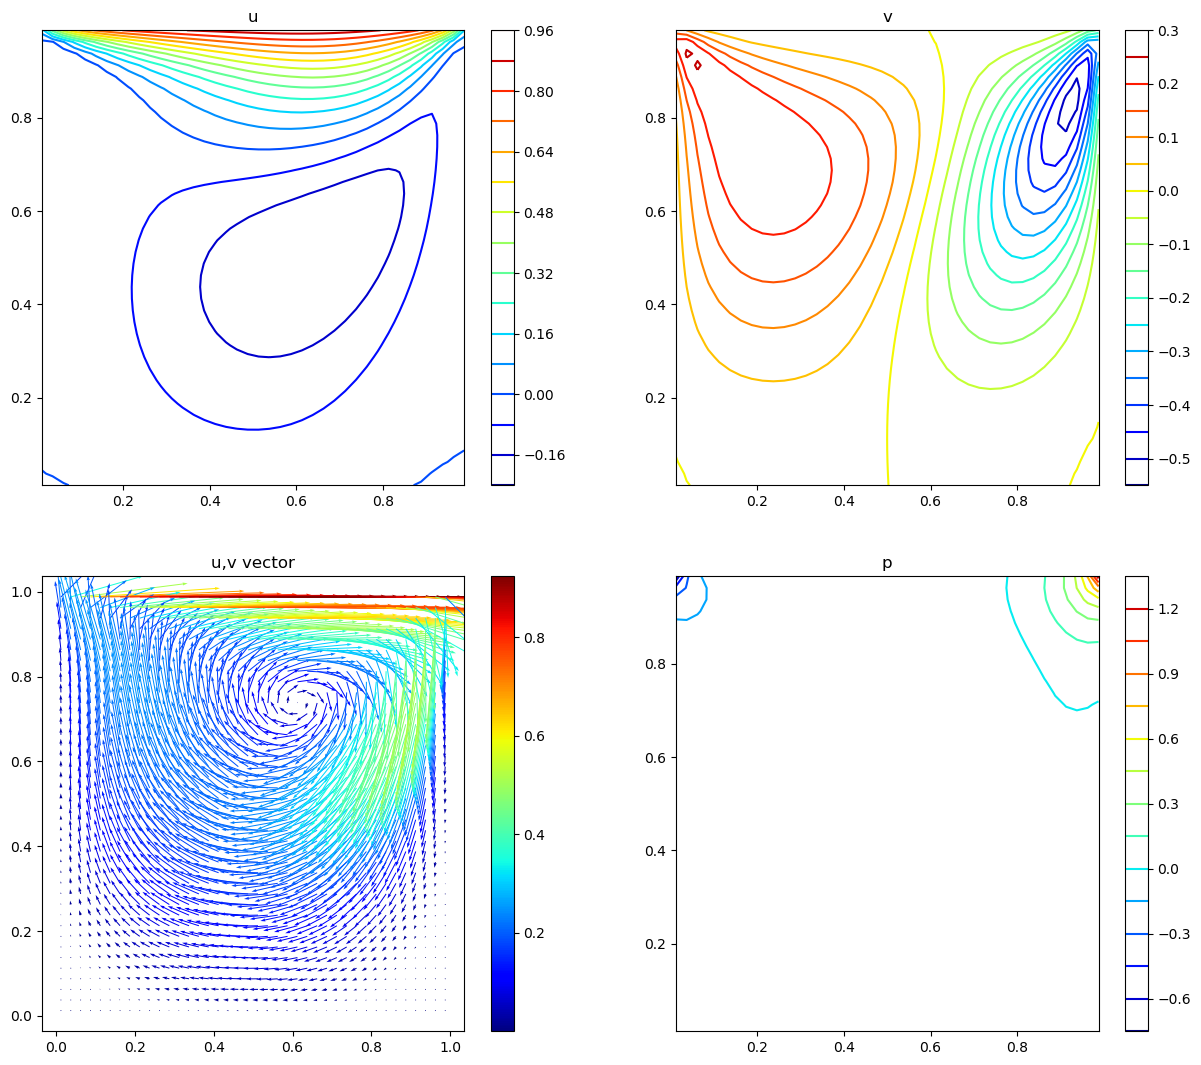

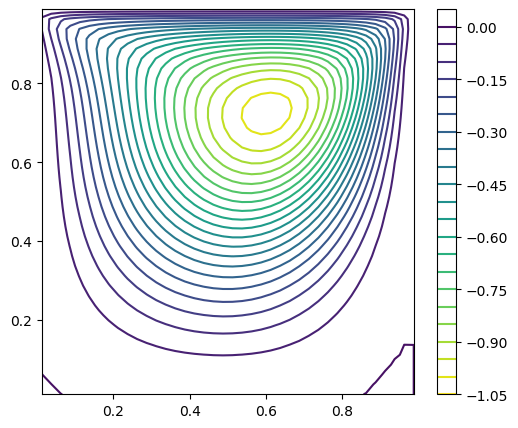

In [22]:
name = "uv20.0"
filename = "Data/"*name*".h5"
file = h5open(filename, "r") 
u = read(file, "U")
v = read(file, "V")
x = read(file, "X")
y = read(file, "Y")
pa = read(file, "P")
psi = read(file, "Psi")

close(file)

X = x[:,1]
Y = y[1,:]
fig = plt.figure(figsize = (15, 13))
ax1 = fig.add_subplot(221)
heatmap = ax1.contour(X', Y, u', cmap="jet", levels=15 )
fig.colorbar(heatmap, ax=ax1)
ax1.set_title("u")

ax2 = fig.add_subplot(222)
heatmap2 = ax2.contour(X', Y, v', cmap="jet", levels=15)
fig.colorbar(heatmap2, ax=ax2)
ax2.set_title("v")

ax3 = fig.add_subplot(223)
umag = sqrt.(u.*u .+ v.*v)
#image = ax3.quiver(x[:, 20:40], y[:, 20:40], u[:, 20:40], v[:, 20:40], umag, scale=4, cmap="jet")
image = ax3.quiver(x[:, :], y[:, :], u[:,:], v[:, :], umag, scale=2, cmap="jet")
#image = ax3.streamplot(x', y', u, v)
cb=fig.colorbar(image, ax=ax3)
ax3.set_title("u,v vector")

ax4 = fig.add_subplot(224)
heatmap3 = ax4.contour(X', Y, pa', cmap="jet", levels=15)
fig.colorbar(heatmap3, ax=ax4)
ax4.set_title("p")
plt.savefig("Fig/uv-vec"*name*".png")

fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(111)
st = ax1.contour(X', Y, psi', cmap="viridis_r", levels=20)
fig.colorbar(st, ax=ax1)
plt.savefig("Fig/stream"*name*".pdf")


